In [ ]:
# REFERNCE & DEBUG: CHATGPT
# Author: Roy Li(Primary), ChatGPT 4.0(Support)

import pandas as pd
import networkx as nx
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import girvan_newman
import itertools

import numpy as np

np.random.seed(1)


csv_file_path = '/content/ProcessedFalseScaled.csv'

df = pd.read_csv(csv_file_path)

G_false = nx.Graph()

for index, row in df.iterrows():
    G_false.add_edge(row['Source'], row['Target'], weight=row['Weight'])

In [ ]:
import numpy as np

np.random.seed(1)


csv_file_path = '/content/ProcessedTrueScaled.csv'

df = pd.read_csv(csv_file_path)

G_true = nx.Graph()

for index, row in df.iterrows():
    G_true.add_edge(row['Source'], row['Target'], weight=row['Weight'])

In [ ]:
import numpy as np

np.random.seed(1)

all_nodes_false = list(G_false.nodes)
print(len(all_nodes_false))
all_nodes_true = list(G_true.nodes)
print(len(all_nodes_true))

merged_nodes = list(set(all_nodes_false + all_nodes_true))

print(len(merged_nodes))

2614
2425
3354


In [ ]:
import numpy as np

np.random.seed(1)


csv_file_path_false = '/content/ProcessedFalseScaled.csv'
csv_file_path_true = '/content/ProcessedTrueScaled.csv'

df_false = pd.read_csv(csv_file_path_false)
df_true = pd.read_csv(csv_file_path_true)

G_initial = nx.Graph()

for index, row in df_false.iterrows():
    G_initial.add_edge(row['Source'], row['Target'], weight=row['Weight'])

for index, row in df_true.iterrows():
    G_initial.add_edge(row['Source'], row['Target'], weight=row['Weight'])



In [ ]:
import numpy as np

np.random.seed(1)


csv_file_path_false = '/content/ProcessedFalseScaled.csv'
csv_file_path_true = '/content/ProcessedTrueScaled.csv'

df_false = pd.read_csv(csv_file_path_false)
df_true = pd.read_csv(csv_file_path_true)

G_initial_step2 = nx.Graph()

for index, row in df_false.iterrows():
    G_initial_step2.add_edge(row['Source'], row['Target'], weight=row['Co_Occurrence'])

for index, row in df_true.iterrows():
    G_initial_step2.add_edge(row['Source'], row['Target'], weight=row['Co_Occurrence'])

for node in G_initial_step2.nodes():
    if node in G_false and node in G_true:
        G_initial_step2.nodes[node]['truth'] = 'mix'
    elif node in G_false:
        G_initial_step2.nodes[node]['truth'] = 'false'
    elif node in G_true:
        G_initial_step2.nodes[node]['truth'] = 'true'
    else:
        G_initial_step2.nodes[node]['truth'] = 'unknown'


for node, data in G_initial_step2.nodes(data=True):
    if data['truth'] == 'mix':
        degree_false = G_false.degree(node) if node in G_false else 0
        degree_true = G_true.degree(node) if node in G_true else 0

        if degree_false > degree_true:
            G_initial_step2.nodes[node]['truth'] = 'false'
        elif degree_true > degree_false:
            G_initial_step2.nodes[node]['truth'] = 'true'

gml_file_path = 'G_initial_step3.gml'
nx.write_gml(G_initial_step2, gml_file_path)



In [ ]:
import community.community_louvain
from collections import Counter


import numpy as np

np.random.seed(1)


gml_file_path = '/content/G_initial_step3.gml'
G = nx.read_gml(gml_file_path)

partition = community.community_louvain.best_partition(G)

community_sizes = Counter(partition.values())

modularity_score = community.community_louvain.modularity(partition, G)


In [ ]:
import networkx as nx
import community.community_louvain as community_louvain
from collections import defaultdict


import numpy as np

np.random.seed(1)


gml_file_path = '/content/G_initial_step3.gml'
G = nx.read_gml(gml_file_path)

partition = community.community_louvain.best_partition(G)


community_to_nodes = defaultdict(list)
for node, comm in partition.items():
    community_to_nodes[comm].append(node)


results = defaultdict(dict)

for comm, nodes in community_to_nodes.items():
    for node_type in ['true', 'false']:
        type_nodes = [n for n in nodes if G.nodes[n].get('truth') == node_type]
        subG = G.subgraph(type_nodes)

        if len(subG) == 0:
            continue

        clustering_coeff = nx.average_clustering(subG)

        if nx.is_connected(subG):
            avg_shortest_path_length = nx.average_shortest_path_length(subG)
        else:
            largest_cc = max(nx.connected_components(subG), key=len)
            largest_subG = subG.subgraph(largest_cc)
            avg_shortest_path_length = nx.average_shortest_path_length(largest_subG)

        results[comm][f'{node_type}_clustering_coeff'] = clustering_coeff
        results[comm][f'{node_type}_avg_shortest_path_length'] = avg_shortest_path_length

for comm, metrics in results.items():
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")


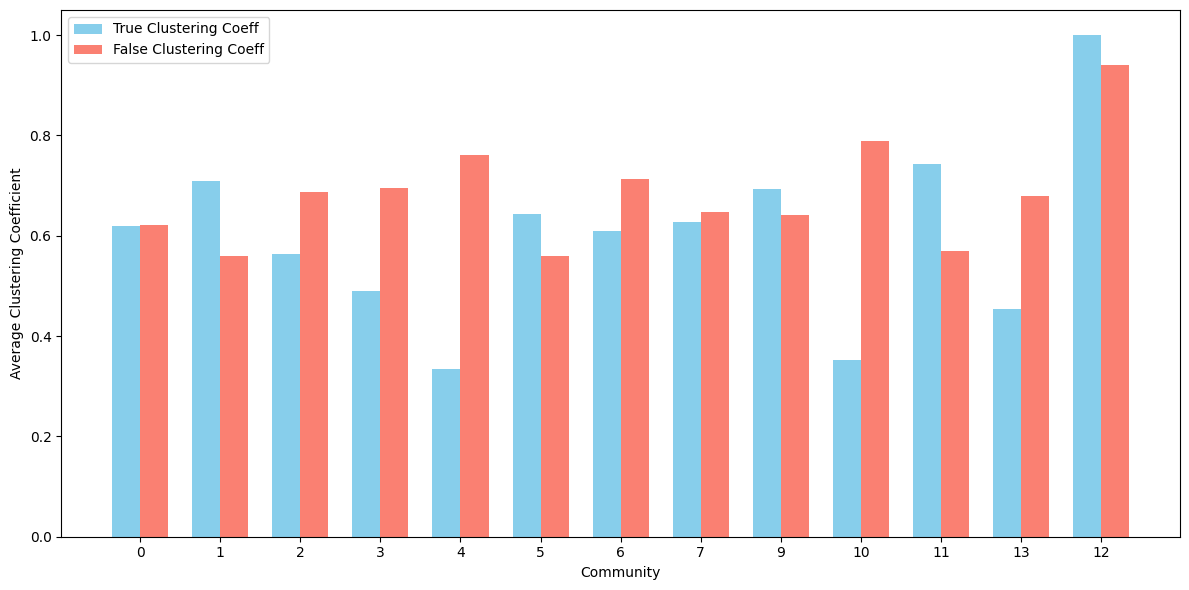

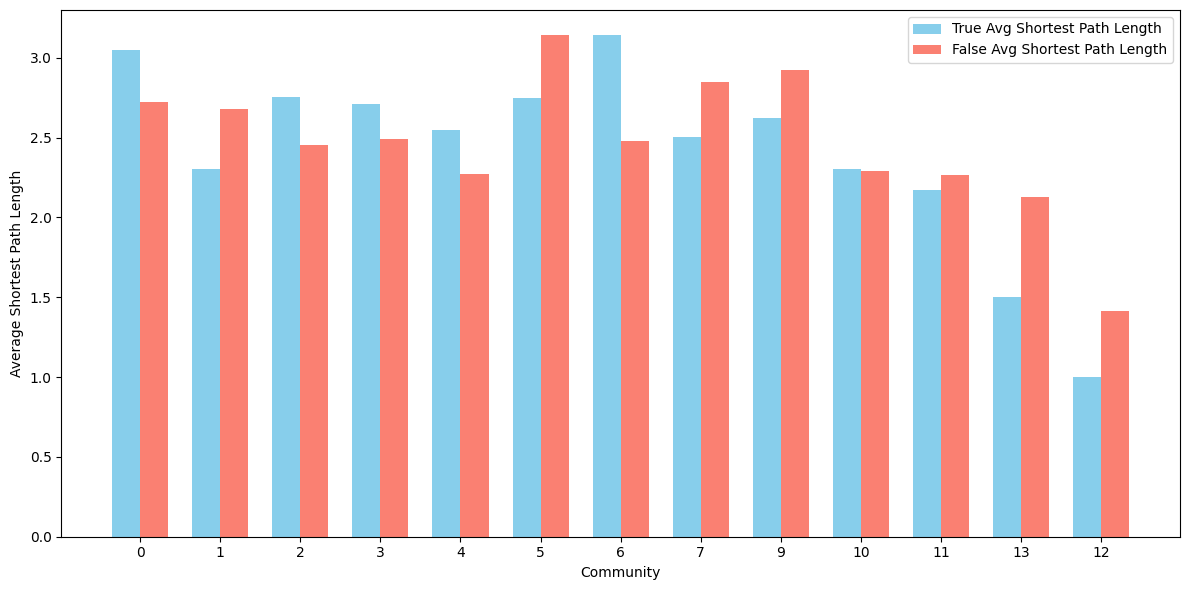

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


communities = list(results.keys())

communities = [comm for comm in communities if 'true_clustering_coeff' in results[comm]]


true_clustering_coeffs = [results[comm]['true_clustering_coeff'] for comm in communities]
false_clustering_coeffs = [results[comm]['false_clustering_coeff'] for comm in communities]
true_avg_shortest_paths = [results[comm]['true_avg_shortest_path_length'] for comm in communities]
false_avg_shortest_paths = [results[comm]['false_avg_shortest_path_length'] for comm in communities]

bar_width = 0.35
index = np.arange(len(communities))


plt.figure(figsize=(12, 6))
plt.bar(index, true_clustering_coeffs, bar_width, label='True Clustering Coeff', color = 'skyblue')
plt.bar(index + bar_width, false_clustering_coeffs, bar_width, label='False Clustering Coeff', color = 'salmon')

plt.xlabel('Community')
plt.ylabel('Average Clustering Coefficient')
plt.xticks(index + bar_width / 2, communities)
plt.legend()

plt.tight_layout()
plt.savefig('coef.png')
plt.show()


plt.figure(figsize=(12, 6))
plt.bar(index, true_avg_shortest_paths, bar_width, label='True Avg Shortest Path Length', color = 'skyblue')
plt.bar(index + bar_width, false_avg_shortest_paths, bar_width, label='False Avg Shortest Path Length', color = 'salmon')

plt.xlabel('Community')
plt.ylabel('Average Shortest Path Length')
plt.xticks(index + bar_width / 2, communities)
plt.legend()

plt.tight_layout()
plt.savefig('short.png')
# plt.close()
plt.show()


